In [ ]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import multiprocessing as mp
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

Understand the deflection angle from a keplerian hyperbolic trajectory

Notes. 

- You can solve for the eccentricity based on the deflection angle, which is cool
- You also find what the minimum impact parameter is. Amazingly, it was the distance at which you would have a bound orbit! 
- Also, you have to realize that the solution for the position as a function of the true anomonly, gives negative solutions for e>1. at least given the typical expression for the radius as a function of distance. This was making it hard to interprete the trajectory in the polar plane. So for me, it's better to write the trajectory as: 
$$ r\left(\psi\right) = \frac{a(e-1)}{1+e\cos\left(\psi\right)}$$


- also, to get the solution of the change in momentum of the particle that is flying by, you still can use the impulse approximation, or the argument that the magnitude of the exchanged momentm is $\vec{F} \Delta t \approx \frac{Gm}{b^2}\frac{2b}{v}$. So you know this is how much momentum the stationary particle is picking up, and this it's initial momentum is zero. However, you have to realize that $p_f \cdot P_o \neq 0$, where $p_f$ is the final momentum of the stationary one and $P_o$ is the initial velocity of the impactor... Instead, you realize that $p_f$ is along the line of symmetry for the hyperbola.This allows you to continue without solving for the integral. 

In [ ]:
def r(true_anomaly, a, e, psi0):
    """Calculate the radius at a given true anomaly for a hyperbolic orbit."""
    return a * (e - 1) / (1 - e * np.cos(true_anomaly+psi0))

In [ ]:
def mean_anomaly(true_anomaly, e):
    """Calculate the mean anomaly from the true anomaly for a hyperbolic orbit."""
    return np.arccosh((1 + e * np.cos(true_anomaly)) / (e * np.cos(true_anomaly)))

In [ ]:
# I solved for the eccentricity based no the deflection angle 
deflectionangle = np.pi/3
a = 1 
e = 1/np.cos((np.pi-deflectionangle)/2)
print(e)
psi0=0
print(np.acos(-1/e)*180/np.pi)  # This is the angle at which the orbit crosses the x-axis

In [ ]:
true_anomalies = np.linspace(-0.9*np.acos(1/e),0.9*np.acos(1/e) ,100)
myr = -r(true_anomalies, a, e,psi0)
# make the xy array
theta = mean_anomaly(true_anomalies, e)
xy = np.array([myr * np.cos(true_anomalies), myr * np.sin(true_anomalies)]).T
cond = myr>0
fig = plt.figure(figsize=(10, 5))
ax1= fig.add_subplot(121, projection='polar')
ax2 = fig.add_subplot(122)
# make the first plot in polar coordinates
ax1.plot(true_anomalies[cond],myr[cond], label='Hyperbolic Orbit )')
ax1.set_title('Hyperbolic Orbit in Polar Coordinates')
ax1.set_xlabel('True Anomaly (radians)')
ax1.set_ylabel('Radius (AU)')
ax2.plot(xy[cond, 0], xy[cond, 1], )
ax2.set_aspect('equal')
plt.grid(True)

# two body relaxation time as a random walk ?

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import multiprocessing as mp
import twoBodyRelaxation as TBR

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

In [ ]:
def set_integration_parameters(norbits=4,dtfactor=1/1000):
    speed = 1 # normalized to np.sqrt(GM/a) where M = m*NP
    tdyn = 2*np.pi / speed
    dt = tdyn * dtfactor
    inttime = norbits * tdyn  
    nsteps = int( inttime / dt)
    return speed, dt, nsteps

def integrate_in_finite_box(NP, cutBmin=True, norbits=4, dtfactor=1/1000, x0 = np.array([-1/2, 0, 0]), v0 = np.array([1,0,0])):
    """Find the random walk of a particle in a gravitational field in a finite box
        This is normalized to the total mass of the system, which is m*NP
        and G =1 for simplicity, and the radius (width/2) of the system = 1. 
        to rescale, multiple v*sqrt(GM/a) where M = m*NP and a is the radius of the system.
        and multiple x*a
    """
    # Initialize positions and velocities
    x = np.random.uniform(-0.5, 0.5, NP)
    y = np.random.uniform(-0.5, 0.5, NP)
    z = np.random.uniform(-0.5, 0.5, NP)
    positions = np.array([x, y, z]).T
    # Initial velocities
    speed, dt, nsteps = set_integration_parameters(norbits=norbits, dtfactor=dtfactor)
    # do the random walk computation
    v=np.zeros((nsteps+1, 3))
    x=np.zeros_like(v)
    v[0]= v0
    x[0] = x0
    for i in range(nsteps):
        dx= positions - x[i]
        speed = np.linalg.norm(v[i])
        quantity=np.dot(v[i],dx.T)/ speed**2
        bmin = 2/(NP*speed**2)
        # to be inside the plane perpendicular to the trajectory, the distance to the line must be less than dx
        condA = -quantity < dt
        condB = quantity < dt
        cond = np.logical_and(condA,  condB)
        # reproject for each impact parameter by replacing the particles on the line perpendicular to the trajectory
        # we want no drift in speed, just direction
        b = dx[cond] - np.outer(np.dot(dx[cond], v[i]), v[i])/ speed**2
        b_mag = np.linalg.norm(b, axis=1)
        # compute the minimum allowed impact parameter, which is the distance at which a binary would form
        if cutBmin:
            condC = b_mag > bmin
            b = b[condC]
            b_mag = b_mag[condC]
        if len(b) == 0:
            impulse = np.zeros((3,2))
        else:
            impulse = 2 / (NP*speed*b_mag**2) * b.T
        v[i+1] = v[i] + impulse.sum(axis=1)
        x[i+1] = x[i] + v[i+1] * dt
    return x, v, positions

In [ ]:
def deprojection_coordinate_system(vel):
    """ Create an arbitrary axes perpendicular to the trajectory """
    speed = np.linalg.norm(vel)
    unitV = vel / speed
    if abs(unitV[0]) < 0.9:
        temp = np.array([1, 0, 0])
    else:
        temp = np.array([0, 1, 0])
    n1 = np.cross(unitV, temp)
    n1 /= np.linalg.norm(n1)
    n2 = np.cross(unitV, n1)
    n2 /= np.linalg.norm(n2)
    return unitV, n1, n2

def deproject_plane_to_3D_space(u, v, position, vel, dt):
    """ u and v are the coordinates in the plane perpendicular to the trajectory, 
    deproject them into 3D space using the position and velocity of the particle."""
    unitV, n1, n2= deprojection_coordinate_system(vel)
    shift=np.random.uniform(-1/2,1/2)*dt*vel
    deprojected = position + u[:, np.newaxis] * n1 + v[:, np.newaxis] * n2 + shift
    return deprojected

def deproject_all_particles(us, ws, x, v, dt):
    """ Deproject all particles from the plane perpendicular to the trajectory into 3D space. """
    xdp = []
    ydp = []
    zdp = []
    for i in range(len(us)):
        deprojected = deproject_plane_to_3D_space(us[i], ws[i], x[i], v[i], dt).T
        nsamps = deprojected.shape[1]
        for j in range(nsamps):
            xdp.append(deprojected[0, j])
            ydp.append(deprojected[1, j])
            zdp.append(deprojected[2, j])
    return np.array(xdp), np.array(ydp), np.array(zdp)


In [ ]:
def experiment_always_in_the_center(NP, norbits=10, dtfactor=1/1000, x0=np.array([-1, 0, 0]), v0=np.array([1, 0, 0]),cutBmin=True):
    """ Run the experiment where particles are always within a certain distance of the trajectory. """

    speed, dt, nsteps = set_integration_parameters(norbits=norbits, dtfactor=dtfactor)
    numberDensity = 3*NP/(4*np.pi)
    print("expectation in disk: ", numberDensity * speed * dt)
    bmin = 2/(NP*speed**2)  # Minimum impact parameter for binary formation
    x = np.zeros((nsteps+1, 3))
    v = np.zeros((nsteps+1, 3))
    x[0] = x0
    v[0] = v0
    i=0
    us = []
    ws = []
    for i in range(nsteps):
        speed = np.linalg.norm(v[i])
        Ndisk = np.random.poisson(numberDensity*speed*dt)
        unitV, n1, n2 = deprojection_coordinate_system(v[i])
        if Ndisk == 0:
            mean_impulse = np.zeros(3)
            u=np.array([])
            w=np.array([])
        else:
            R = np.random.uniform(0, 1, Ndisk)**(1/2)
            theta = np.random.uniform(0, 2*np.pi, Ndisk)
            u,w= np.cos(theta) * R, np.sin(theta) * R
            # now compute the forces on the particle in this plane 
            b = np.array([np.zeros_like(u),u,w]).T
            # I need to compute the forces that will be along this trajectory
            b_mag=np.linalg.norm(b,axis=1)
            # cut the impact parameter if it is too small
            if cutBmin:
                cond = b_mag > bmin
                b = b[cond]
                b_mag = b_mag[cond]
            if len(b) == 0:
                mean_impulse = np.zeros(3)
            else:
                # compute the impulse 
                impulse=2/(NP*speed*b_mag**2) * b.T
                impulse.shape
                # now I need to add this to the velocity of the particle
                # get the mean impulse
                mean_impulse = impulse.mean(axis=1)
            # deproject the mean impulse and apply it to the mean velocity
        v[i+1,:] = v[i] + n1*mean_impulse[1] + n2*mean_impulse[2]
        x[i+1,:] = x[i] + v[i+1] * dt
        us.append(u)
        ws.append(w)
    return x, v, us, ws


In [ ]:
def run_trial(args):
    NP, norbits, dtfactor, x0, v0, dt = args
    x, v, u, w = experiment_always_in_the_center(NP, norbits=norbits, dtfactor=dtfactor, x0=x0, v0=v0)
    xdp, ydp, zdp = deproject_all_particles(u, w, x, v, dt)
    return x, v, u, w, xdp, ydp, zdp

In [48]:
trials = 5
NP = int(1e3)
tdyn = 1
trelax = (np.pi / 6) * tdyn * NP / np.log(NP / 2)
trelax =  tdyn * NP / np.log(NP) / 10 
norbits = 2
dtfactor = 1 / 1000
x0 = np.array([-1, 0, 0])
v0 = np.array([1, 0, 0])
speed, dt, nsteps = TBR.set_integration_parameters(norbits=norbits, dtfactor=dtfactor)
ncpu = mp.cpu_count() - 2
# Prepare arguments for each trial
args_list = [(NP, norbits, dtfactor, x0, v0, dt) for _ in range(trials)]

with mp.Pool(ncpu) as pool:
    results = pool.map(TBR.run_trial_experiment_always_in_the_center, args_list)

# Unpack results
xs, vs, us, ws, xdps, ydps, zdps = zip(*results)

tsteps = np.arange(nsteps) * dt

expectation in disk:  1.5000000000000002
expectation in disk:  1.5000000000000002
expectation in disk:  1.5000000000000002
expectation in disk:  1.5000000000000002
expectation in disk:  1.5000000000000002


In [49]:
deltaV2s = []
for i in range(trials):
    v = vs[i]
    deltaV2 = np.cumsum(np.sum(np.diff(v**2, axis=0), axis=1)) / speed**2
    deltaV2s.append(deltaV2)

timesteps = np.arange(nsteps+1) * dt  # shape: (Nstep+1,)

(0.0, 5.0)

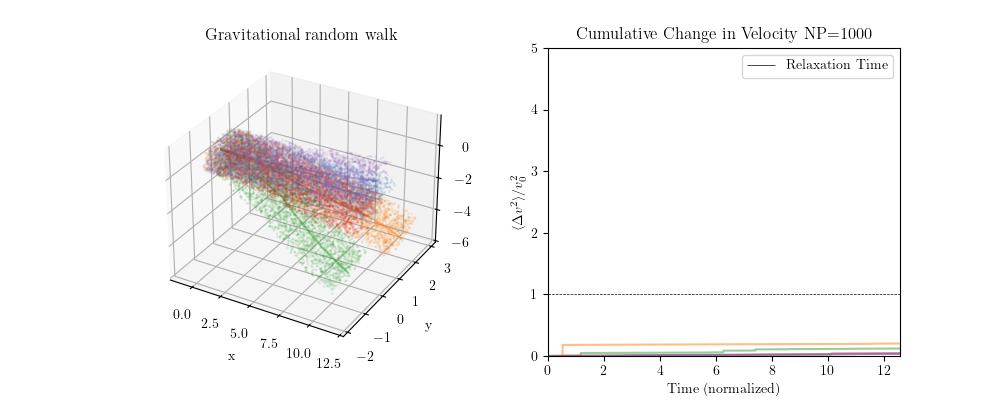

In [50]:
fig= plt.figure(figsize=(10, 4))

axis=[]
axis.append(fig.add_subplot(121, projection='3d'))
axis.append(fig.add_subplot(122))
NSKIP=1

for i in range(trials):
    axis[1].plot(tsteps, deltaV2s[i], alpha=0.5, )
    line,=axis[0].plot(xs[i][:, 0], xs[i][:, 1], xs[i][:,2], alpha=0.5)
    axis[0].scatter(xdps[i][::NSKIP], ydps[i][::NSKIP], zdps[i][::NSKIP], s=1, alpha=0.1, label='Particles',color=line.get_color())
axis[0].set_title('Gravitational random walk ')
axis[0].set_xlabel('x')
axis[0].set_ylabel('y')
axis[1].vlines(trelax, 0, 5, color='k', linestyle='-', lw=.5, label='Relaxation Time')
axis[1].hlines(1, 0, tsteps[-1], color='k', linestyle='--', lw=.5, )
axis[1].set_ylabel(r"$\langle\Delta v^2\rangle / v_0^2$")
axis[1].set_xlabel('Time (normalized)')
axis[1].set_title(r'$\mathrm{{Cumulative}}~\mathrm{{Change~in~Velocity~}}$NP={}'.format(NP))
axis[1].set_xlim(0, tsteps[-1])
axis[1].legend()
axis[1].set_ylim(0, 5)

In [ ]:
NP=int(1e3)
dtfactor=1/1001
norbits= 2
x0= np.array([-1, 0, 0])  # Initial position
v0= np.array([1, 0, 0])  # Initial velocity direction
speed, dt, nsteps = set_integration_parameters(norbits=norbits,dtfactor=dtfactor)
t= np.linspace(0, norbits/speed, nsteps+1)
nTests = 100
x = np.zeros((nTests, nsteps+1, 3))
v = np.zeros((nTests, nsteps+1, 3))
for i in range(nTests):
    x_, v_, positions = integrate_in_finite_box(NP, norbits=norbits, dtfactor=dtfactor, x0=x0, v0=v0, cutBmin=False)
    x[i] = x_
    v[i] = v_

In [ ]:
dv2=np.cumsum(np.sum(np.diff(v[i], axis=0,)**2,axis=1))

In [ ]:
t=np.arange(nsteps+1) * dt
tcol=NP/np.log(NP) / 12
magV = np.linalg.norm(v, axis=-1)
fig,axis= plt.subplots(1, 1, figsize=(6.25, 2.5))
for i in range(nTests):
    axis.plot(t, magV[i], label='Velocity magnitude')
ylims = axis.get_ylim()

axis.vlines(tcol, *ylims, color='red', linestyle='--', label='Collision time')
axis.set_xlabel('Time (normalized)')
axis.set_ylabel('Velocity magnitude (normalized)')
axis.set_title('Velocity Magnitude Over Time')
axis.set_ylim([0,2])


In [ ]:
fig,axis= plt.subplots(figsize=(8.25-2, 2))


for i in range(nTests):
    i = 0
    # undeflected trajecotry: 
    x_undeflected = np.zeros_like(x[i])
    x_undeflected[:,0] = x[i,0,0] + v[i,0,0] * dt * np.arange(nsteps+1)
    x_undeflected[:,1] = x[i,0,1] + v[i,0,1] * dt * np.arange(nsteps+1)
    x_undeflected[:,2] = x[i,0,2] + v[i,0,2] * dt * np.arange(nsteps+1)
    dv2=np.cumsum(np.sum(np.diff(v[i], axis=0,)**2,axis=1))
    t=np.arange(nsteps) * dt
    axis.plot(t, dv2, label='Cumulative Change in Velocity')
axis.vlines(tcol, 0, dv2.max(), color='red', linestyle='--', label='Time of Interaction')

In [ ]:
NSHOW = 1000
NSKIP = NP//NSHOW
if NSKIP == 0:
    NSKIP = 1

In [ ]:
i=11
fig=plt.figure(figsize=(8.25-2, 2))
axis=fig.add_subplot(121, projection='3d')
axis2=fig.add_subplot(122, frame_on=False)
axis.scatter(positions[::NSKIP, 0], positions[::NSKIP, 1], positions[::NSKIP, 2], s=0.5, alpha=0.1, color='black')
axis.plot(x[i,:, 0], x[i,:, 1], x[i,:, 2], color='orange', label='Trajectory after Interaction')
axis.plot(x_undeflected[:, 0], x_undeflected[:, 1], x_undeflected[:, 2], color='blue', linestyle='--', label='Undeflected Trajectory')
axis.set_xlabel('X')
axis.set_ylabel('Y')
axis.set_zlabel('Z')
axis.set_title('3D Trajectory after Interaction')
axis.view_init(elev=20, azim=-60)
axis.set_xlim([-1,1])
axis.set_ylim([-1,1])
axis.set_zlim([-1,1])

axis2.plot(x[:, 0], x[:, 1], color='orange', label='Trajectory after Interaction')
axis2.plot(x_undeflected[:, 0], x_undeflected[:, 1],color='blue', linestyle='--', label='Undeflected Trajectory')
axis2.set_xlabel('X')
axis2.set_ylabel('Y')
axis2.set_title('2D Projection of Trajectory')
axis2.set_aspect('equal')
plt.show()

In [ ]:
dv2=np.cumsum(np.sum(np.diff(v, axis=0,)**2,axis=1))
t=np.arange(nsteps) * dt
fig,axis= plt.subplots(figsize=(8.25-2, 2))
axis.plot(t, dv2, label='Cumulative Change in Velocity')
axis.vlines(tcol, 0, dv2.max(), color='red', linestyle='--', label='Time of Interaction')

In [ ]:
import astropy.units as u
from astropy.constants import G
unitL = u.kpc
unitV = u.km/u.s
unitM = u.Msun
unitG = unitV**2 * unitL/unitM 
G= G.to(unitG).value
NP = int(1e3)
boxsize = 10
m=1
mass_system = m * NP

In [ ]:
bmin=2*G*m/((220)**2) * unitL
bmin.to(u.Rsun)